# Задача классификации

![Classification](pics/cat.jpg  "")

*Задача классификации* — это задача присвоения меток объектам. Например, если объекты — это фотографии, то метками может быть содержание фотографий: содержит ли изображение пешехода или нет, изображен ли мужчина или женщина, какой породы собака изображена на фотографии. Обычно есть набор взаимоисключающих меток и сборник объектов, для которых эти метки известны. Имея такую коллекцию данных необходимо автоматически расставлять метки на произвольных объектах того же типа, что были в изначальной коллекции.

## __Всё гениальное просто, и всё простое гениально__

### Дерево решений

Рассмотрим задачу классификации на примере. Пусть мы берем с полки в магазине некоторую книгу, которую никогда не читали, и хотим понять, к какому жанру она относится. У нас уже есть багаж прошлого опыта, на основе которого мы можем сформулировать несколько простых правил:
1. Мы знаем, что, если книга красная, то это точно не хоррор и не автобиография. 
2. Если книга с глянцевой обложкой, то это не техническая литература.
3. Если в название книге есть какие-то даты, то очень маловероятно, что книга относится к художественной литературе.
4. Если на обложке изображен человек, то книга точно не к учебник по медицине и не энциклопедия.
5. Если на обложке изображен известный человек, то это книга об истории.

...

![Genius](pics/book.jpeg  "")

Таким образом, одним из способов дать ответ на вопрос, на который мы его не знаем, является составление с помощью нашего жизненного опыта некоторых простых правил, на основе которых можно отметать неверные варианты ответа. В классическом программирование мы рашаем эту задачу с помощью операторов `if` и `match`:

In [ ]:
if book_cover == "famous human":
    print('history')
elif book_cover == "human":
    if book_color == "read":
        classes.remove(['horror', 'autobiography'])
        ...

Однако, что, если эти простые правила не очевидны, или нужно рассмотреть слишком много случаев, или их сложно упорядочить? Не писать же миллион операторов `if` в надежде, что все само фейрверком взорвется? Тут нам на помощь приходит машинное обучение! На основе данной простой идеи строится алгоритм дерева решения. 

![Tree](pics/tree.jpg  "")

### Как строится дерево решений?

В основе построения дерева решений лежит понятие энтропии. Энтропия - это величина, которая принимает значение в диапозоне [0, 1] и итнерпретируется как степень неопределенности:
$$\Large S = -\sum_{i=1}^{N}p_i \log_2{p_i},$$
где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. Это очень важное понятие, используемое в физике, теории информации и других областях. Чем выше энтропия, тем менее упорядочена система и наоборот. За счет ее минимизации и строится максимально информативные правила (вершины) дерева решенеий.

### Пример с шариками

Для иллюстрации того, как энтропия поможет определить хорошие признаки для построения дерева, приведем тот же игрушечный пример, что в статье "Энтропия и деревья принятия решений". Будем предсказывать цвет шарика по его координате. Конечно, ничего общего с жизнью это не имеет, но позволяет показать, как энтропия используется для построения дерева решений.

![Шарики](pics/balls/1.png)

Здесь 9 синих шариков и 11 желтых. Если мы наудачу вытащили шарик, то он с вероятностью $p_1=\frac{9}{20}$ будет синим и с вероятностью $p_2=\frac{11}{20}$ – желтым. Значит, энтропия состояния $$S_0 = -\frac{9}{20}\log_2{\frac{9}{20}}-\frac{11}{20}\log_2{\frac{11}{20}} \approx 1$$ Само это значение пока ни о чем нам не говорит. Теперь посмотрим, как изменится энтропия, если разбить шарики на две группы – с координатой меньше либо равной 12 и больше 12.

![Шарики](pics/balls/2.png)

В левой группе оказалось 13 шаров, из которых 8 синих и 5 желтых. Энтропия этой группы равна $$S_1 = -\frac{5}{13}\log_2{\frac{5}{13}}-\frac{8}{13}\log_2{\frac{8}{13}} \approx 0.96$$ В правой группе оказалось 7 шаров, из которых 1 синий и 6 желтых. Энтропия правой группы равна $$S_2 = -\frac{1}{7}\log_2{\frac{1}{7}}-\frac{6}{7}\log_2{\frac{6}{7}} \approx 0.6$$ Как видим, энтропия уменьшилась в обеих группах по сравнению с начальным состоянием, хоть в левой и не сильно.

Остальные действия оставим на откуп читателю.

### Пример

Рассмотрим пример применения дерева решений из библиотеки Scikit-learn для синтетических данных. Два класса будут сгенерированы из двух нормальных распределений с разными средними.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# первый класс
np.random.seed(7)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

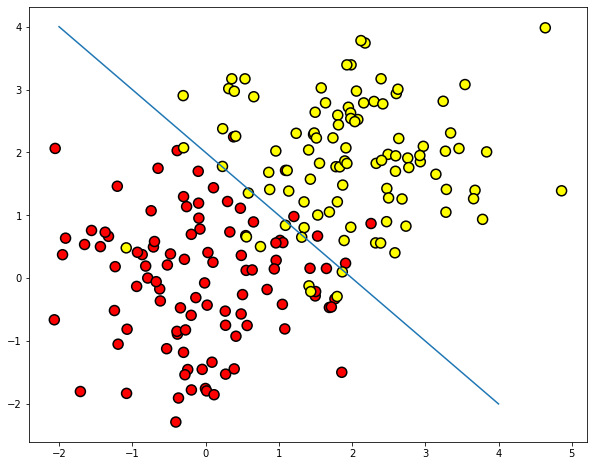

In [69]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1))

In [70]:
# Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей визуализации.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

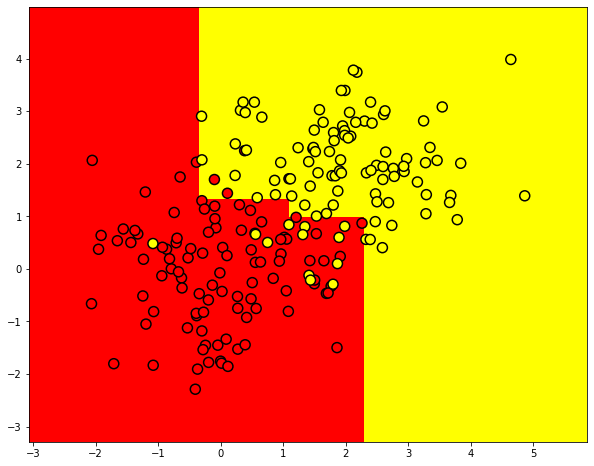

In [71]:
from sklearn.tree import DecisionTreeClassifier

# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=17)

# обучаем дерево
clf_tree.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5)

Визуализируем само дерево решений

In [74]:
# используем .dot формат для визуализации дерева
from sklearn.tree import export_graphviz
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
out_file='small_tree.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng 'small_tree.dot' -o 'small_tree.png'

Error: dot: can't open 'small_tree.dot': No such file or directory


Основные параметры DecisionTreeClassifier из библиотеки Sklearn:

* **max_depth** – максимальная глубина дерева
* **max_features** — максимальное число признаков, по которым ищется лучшее разбиение в дереве (это нужно потому, что при
  большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди всех
  признаков)
* **min_samples_leaf** – минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он
  равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как минимум для 5 объектов

### Другие критерии качества разбиения в задаче классификации

Мы разобрались в том, как понятие энтропии позволяет формализовать представление о качестве разбиения в дереве. Но это всего лишь эвристика, существуют и другие:

* Неопределенность Джини (Gini impurity): $$G = 1 - \sum\limits_k (p_k)^2$$ Максимизацию этого критерия можно интерпретировать как максимизацию числа пар объектов одного класса, оказавшихся в одном поддереве. Подробнее об этом (как и обо многом другом) можно узнать из репозитория Евгения Соколова. Не путать с индексом Джини!
* Ошибка классификации (misclassification error): $E = 1 - \max\limits_k p_k$ (на практике почти не используется)


In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [76]:
train_data = pd.read_csv("prepared_data.csv")
train_data.drop(["Sex", "Embarked", "Name_Prefix", "Lastname", "TicketPre"], axis=1, inplace=True)

train = train_data[train_data["Survived"].notnull()]
labels = train["Survived"]
train = train.drop(["Survived"], axis=1)
test = train_data[train_data["Survived"].isna()]

X_train, X_val, y_train, y_val = train_test_split(train, labels)


print(train.shape)
print(test.shape)

(891, 7)
(418, 8)


In [77]:
clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=17)
clf_tree.fit(X_train, y_train)
predicted_labels_tree = clf_tree.predict(X_val)

In [78]:
predicted_labels_tree

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0.])

### k Nearest Neighbors

Вернемся к задаче классификации книг и посмотрим на нее под другим углом. Вспоминаем, что книгу мы взяли не у бездомного на улице, а с полки в книжном магазине, где продавцы уже заботливо расставили книги по жанрам. Маловероятно, что книга по истории может стоять рядом с художественной литературой. Скорее всего она будет находится там же, где и другие книги по истории. Из этого небольшого умозаключения следует, что ничто лучше не описывает объект, чем его окружение. А значит, что если мы не знаем, что за объект находится перед нами, но знаем объекты, которые его окружают, то мы легко можем дать верный ответ. Такой подход чем-то схож с мышлением через ассоциации в нашей голове. 

В машинном обучение алгоритм, построенный на основе вышеописанной идеи называется метод ближайших соседей (k Nearest Neighbors, или kNN).

Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:

* Вычислить расстояние до каждого из объектов обучающей выборки
* Отобрать $k$ объектов обучающей выборки, расстояние до которых минимально
* Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди $k$ ближайших соседей

In [80]:
from sklearn.neighbors import KNeighborsClassifier

In [85]:
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_knn.fit(X_train, y_train)
predicted_labels_knn = clf_knn.predict(X_val)

### Основные параметры KNeighborsClassifier из библиотеки Sklearn:


* **weights**: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция
* **algorithm** (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем — расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автоматически на основе обучающей выборки.
* **leaf_size** (опционально): порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
* **metric**: "minkowski", "manhattan", "euclidean", "chebyshev" и другие

### Метод ближайших соседей в реальных задачах

* В чистом виде kNN может послужить хорошим стартом (baseline) в решении какой-либо задачи;
* В соревнованиях Kaggle kNN часто используется для построения мета-признаков (прогноз kNN подается на вход прочим моделям) или в стекинге/блендинге;
* Идея ближайшего соседа расширяется и на другие задачи, например, в рекомендательных системах простым начальным решением может быть рекомендация какого-то товара (или услуги), популярного среди ближайших соседей человека, которому хотим сделать рекомендацию;
* На практике для больших выборок часто пользуются приближенными методами поиска ближайших соседей.


### Качество классификации/регрессии методом ближайших соседей зависит от нескольких параметров:

* число соседей
* метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). Отметим, что при использовании большинства метрик значения признаков надо масштабировать. Условно говоря, чтобы признак "Зарплата" с диапазоном значений до 100 тысяч не вносил больший вклад в расстояние, чем "Возраст" со значениями до 100.
* веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос")


## Метрики качества моделей

Ура! Мы обучили свои первые модели машинного обучения! Однако остается открытый вопрос: насколько хорошо мы обучили их? Для ответа на него необходимо посчитать метрики. Самое простое, что приходит в голову для задачи классификации - это посчитать количество правильных предсказаний модели относительно размера всей валидационной выборки.

In [92]:
from sklearn.metrics import accuracy_score

In [91]:
print("Decision Tree accuracy: ", accuracy_score(y_val, predicted_labels_tree))
print("kNN accuracy: ", accuracy_score(y_val, predicted_labels_knn))

Decision Tree accuracy:  0.6995515695067265
kNN accuracy:  0.6860986547085202


Такая метрика называется Accuracy. Она является интуитивно понятной не только для инжинера, но и заказчика. Ее главный минус заключается в том, что она при всех своих плюсах является неифнормативной, не отражая ни слабые, ни сильные стороны модели, а для несбалансированной выборки так и вовсе не отражает качество прогноза модели.

Для перехаода к более сложным абстракциям необходимо рассмотреть все случаи прогноза модели. Пусть $y=1$ "--- это целевой класс модели (в случае с титаником "--- это факт того, что человек выжил). Модель может: 
1. Верно предсказать целевой класс. Сумма таких предсказаний будет называться True Positive (TP).
2. Верно предсказать нецелевой класс. Сумма таких предсказаний будет называться True Negative (TN).
3. Неверно предсказать целевой класс, отнеся его к нецелевому. Сумма таких предсказаний будет называться False Positive (FP).
4. Неверно предсказать нецелевой класс, отнеся его к целевому. Сумма таких предсказаний будет называться False Negative (FN).

Относительно этих четрыех простых фактов по предсказаниям модели можно построить confusion matrix:

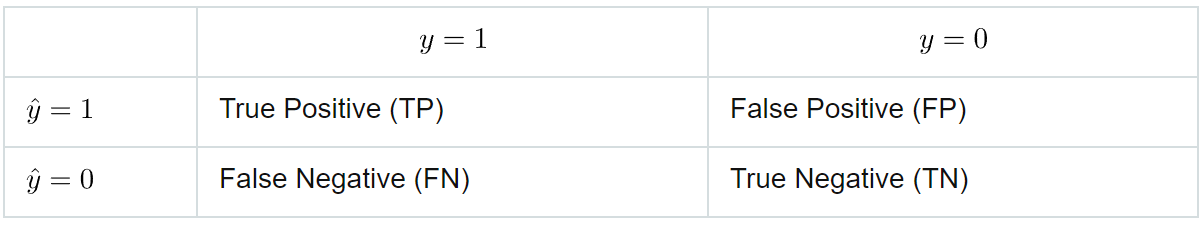

In [103]:
from sklearn.metrics import confusion_matrix

In [104]:
print(confusion_matrix(y_val, predicted_labels_tree))

[[123  10]
 [ 57  33]]


In [111]:
confusion_matrix(y_val, predicted_labels_tree, normalize='pred')

array([[0.68333333, 0.23255814],
       [0.31666667, 0.76744186]])

In [112]:
confusion_matrix(y_val, predicted_labels_tree, normalize='true')

array([[0.92481203, 0.07518797],
       [0.63333333, 0.36666667]])

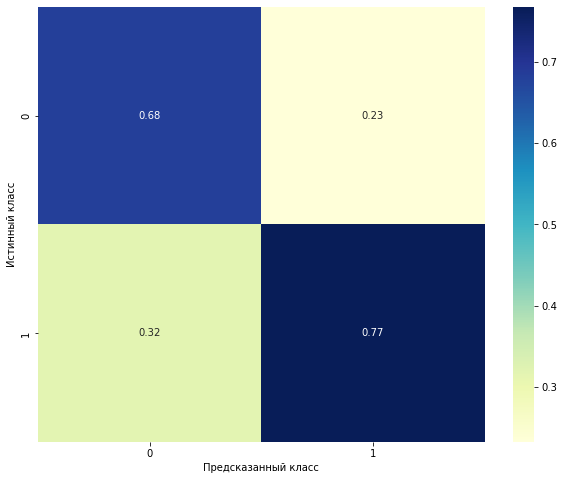

In [110]:
import seaborn as sns
heatmap = sns.heatmap(confusion_matrix(y_val, predicted_labels_tree, normalize='pred'), annot=True, cmap='YlGnBu')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

Данная матрица в нормализованном по осям или столбцам виде уже может выступать в качестве метрик. Однако на практике чаще всего ее значения используют для рассчета других, более простых для понимания метрик.

Выведем через нее уже знакомую нам метрику accuracy:

$$\large accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

Теперь покажем, почему эта метрика может быть не просто не информативной, но еще и не практичной в некоторых случаях. Допустим, мы хотим оценить работу спам-фильтра почты. У нас есть 100 не-спам писем, 90 из которых наш классификатор определил верно (True Negative = 90, False Positive = 10), и 10 спам-писем, 5 из которых классификатор также определил верно (True Positive = 5, False Negative = 5).
Тогда **accuracy**:


$$\ accuracy = \frac{5 + 90}{5 + 90 + 10 + 5} = 86,4% $$


Однако если мы просто будем предсказывать все письма как не-спам, то получим более высокую accuracy:


$$\ accuracy = \frac{0 + 100}{0 + 100 + 0 + 10} = 90,9% $$


При этом, наша модель совершенно не обладает никакой предсказательной силой, так как изначально мы хотели определять письма со спамом. Преодолеть это нам поможет переход с общей для всех классов метрики к отдельным показателям качества классов.

Для того, чтобы лучше понимать нашу модель, вводятся две следующие метрики: precision (точность) и recall (полнота). 

$$ \large precision = \frac{TP}{TP + FP}$$


$$ \large recall = \frac{TP}{TP + FN} $$


Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса из всей выборки нашел алгоритм.


In [93]:
from sklearn.metrics import precision_score, recall_score

In [95]:
print("Decision Tree precision_score: ", precision_score(y_val, predicted_labels_tree))
print("Decision Tree recall_score: ", recall_score(y_val, predicted_labels_tree))
print("")
print("kNN precision_score: ", precision_score(y_val, predicted_labels_knn))
print("kNN recall_score: ", recall_score(y_val, predicted_labels_knn))

Decision Tree precision_score:  0.7674418604651163
Decision Tree recall_score:  0.36666666666666664

kNN precision_score:  0.6724137931034483
kNN recall_score:  0.43333333333333335


Стоит отметить, что целевая метрика для каждой задачи разная. Где-то можно принебречь невысоким показателем не целевой метрики, однако если эта метрика стремится к 0, то это тоже плохо. Например, если модель будет называть все классы положительными, то мы получим $\large recall = 1$, имея низкое значение $\large precision$. Тогда встоет вопрос, чем использование такой модели лучше, чем если бы мы просто относили все поступающие данные к положительному классу по умолчанию?

Для того, чтобы оценить предсказания модели, учитывая обе этих метрики, используют их среднее гармоническое. Данная метрика называется **F-мера** (в общем случае $\ F_\beta$) и рассчитывается по формуле:

$$\large \ F_\beta = (1 + \beta^2) \cdot \frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}$$

$\beta$ в данном случае определяет вес точности в метрике, и при $\beta = 1$ это среднее гармоническое (с множителем 2, чтобы в случае precision = 1 и recall = 1 иметь $\ F_1 = 1$)
F-мера достигает максимума при полноте и точности, равными единице, и близка к нулю, если один из аргументов близок к нулю.
В sklearn есть удобная функция _metrics.classificationreport, возвращающая recall, precision и F-меру для каждого из классов, а также количество экземпляров каждого класса.

In [98]:
from sklearn.metrics import f1_score, fbeta_score

In [102]:
print("Decision Tree f1_score: ", f1_score(y_val, predicted_labels_tree))
print("kNN f1_score: ", f1_score(y_val, predicted_labels_knn))
print("")
b = 0.3
print(f"Decision Tree fbeta_score (b = {b}): ", fbeta_score(y_val, predicted_labels_tree, beta=b))
print(f"kNN fbeta_score (b = {b}): ", fbeta_score(y_val, predicted_labels_knn, beta=b))

Decision Tree f1_score:  0.49624060150375937
kNN f1_score:  0.5270270270270271

Decision Tree fbeta_score (b = 0.3):  0.7039138943248532
kNN fbeta_score (b = 0.3):  0.6431164901664145


## Способы улучшения метрик

Давайте сразу отбросим самые очевидные способы, связанные с количеством и качеством данных. Они и правда работают хорошо, но не всегда существет возможность их применения. Сосредоточимся в данном пункте на самих моделях.

Можно выделить следующие подходы:
1. Смена модели на более сложную.
2. Перебор гиперпараметров.
3. Кросс валидация.

### Перебор гиперпараметров

In [142]:
tree_params = {'max_depth': range(1,11)}

models = []
for depth in tree_params['max_depth']:
    tmp_tree = DecisionTreeClassifier(max_depth=depth)
    tmp_tree.fit(X_train, y_train)
    result = accuracy_score(y_val, tmp_tree.predict(X_val))
    models.append((result, depth)) 

# что будет с результатами, если запустить несколько раз?
sorted(models)

[(0.6457399103139013, 1),
 (0.6502242152466368, 2),
 (0.6502242152466368, 3),
 (0.695067264573991, 7),
 (0.6995515695067265, 6),
 (0.7040358744394619, 4),
 (0.7040358744394619, 5),
 (0.726457399103139, 9),
 (0.7309417040358744, 10),
 (0.7354260089686099, 8)]

### GridSearchCV упрощает жизнь инженеру!

In [115]:
import warnings
warnings.filterwarnings('ignore')

In [143]:
from sklearn.model_selection import GridSearchCV, cross_val_score
tree_params = {'max_depth': range(1,11)}

tree = DecisionTreeClassifier()

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1,
                         verbose=True)

tree_grid.fit(X_train, y_train)

print("best params: ", tree_grid.best_params_)
print("best score: ", tree_grid.best_score_)
accuracy_score(y_val, tree_grid.predict(X_val))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best params:  {'max_depth': 4}
best score:  0.7050723824486589


0.6995515695067265

In [144]:
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(X_train, y_train)
accuracy_score(y_val, tree.predict(X_val))

0.7354260089686099

### Кросс валидация

Остановимся на данном пункте поподробнее. Главная задача обучаемых алгоритмов – их способность обобщаться, то есть хорошо работать на новых данных. Поскольку на новых данных мы сразу не можем проверить качество построенной модели (нам ведь надо для них сделать прогноз, то есть истинных значений целевого признака мы для них не знаем), то надо пожертвовать небольшой порцией данных, чтоб на ней проверить качество модели.

Чаще всего это делается одним из 2 способов:

* отложенная выборка (held-out/hold-out set). При таком подходе мы оставляем какую-то долю обучающей выборки (как правило от 20% до 40%), обучаем модель на остальных данных (60-80% исходной выборки) и считаем некоторую метрику качества модели (например, самое простое – долю правильных ответов в задаче классификации) на отложенной выборке.
* кросс-валидация (cross-validation, на русский еще переводят как скользящий или перекрестный контроль). Тут самый частый случай – K-fold кросс-валидация

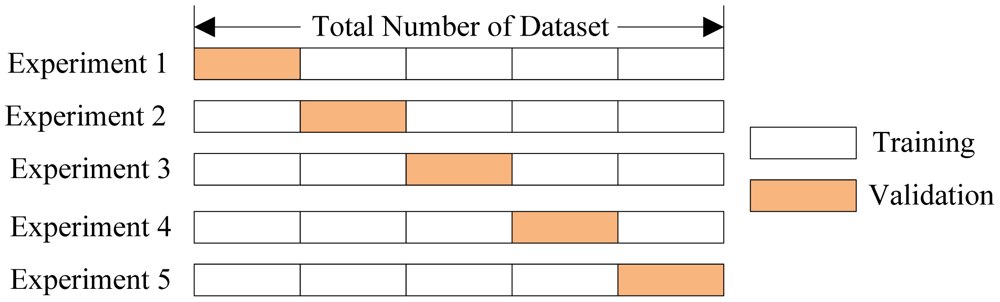

Тут модель обучается $K$ раз на разных ($K-1$) подвыборках исходной выборки (белый цвет), а проверяется на одной подвыборке (каждый раз на разной, оранжевый цвет).
Получаются $K$ оценок качества модели, которые обычно усредняются, выдавая среднюю оценку качества классификации/регрессии на кросс-валидации.


Кросс-валидация дает лучшую по сравнению с отложенной выборкой оценку качества модели на новых данных. Но кросс-валидация вычислительно дорогостоящая, если данных много или модель является очень сложной.

In [145]:
from sklearn.model_selection import cross_val_score

In [148]:
tree = DecisionTreeClassifier(max_depth=10)
cross_val_score(tree, X_train, y_train, cv=4)

array([0.65868263, 0.67065868, 0.66467066, 0.64670659])